<a href="https://colab.research.google.com/github/girijeshcse/car_finder/blob/sushweta/notebook/Car_model_Prepare_Train_and_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAPSTONE PROJECT - Prepare and Pickle Train and Test data

# Load libraries

In [ ]:
import os
import cv2
import csv
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from sklearn.preprocessing import LabelBinarizer


# Mount Drive, change working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change the working directory

In [ ]:
#### Add your code here ####
import os
os.chdir('/content/drive/My Drive/Capstone Data')

# Setup configuration values and variables

In [ ]:
BASE_PATH = "/content/drive/My Drive/Capstone Data"

BASE_OUTPUT = "output"

TRAIN_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Train Images"])
TEST_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Test Images"])
TRAIN_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Train Annotations.csv"])
TEST_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Test Annotation.csv"])
CAR_NAMES_MAKE_DICT = os.path.sep.join([BASE_PATH, "Car names and make.csv"])

# The path to our TensorFlow-serialized output model
MODEL_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "detectorvgg16_V2.h5"])
LB_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "lb.pickle"])

TEST_FILENAMES = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "test_images.txt"])

DF_TRAIN_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "dftrain.pickle"])
DF_TEST_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "dftest.pickle"])

TRAIN_IMAGES_PROCESSED = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "trainimages.pickle"])
TEST_IMAGES_PROCESSED= os.path.sep.join([BASE_PATH, BASE_OUTPUT, "testimages.pickle"])

TRAIN_BBOXES = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "trainbboxes.pickle"])
TEST_BBOXES= os.path.sep.join([BASE_PATH, BASE_OUTPUT, "testbboxes.pickle"])

In [ ]:
# load the contents of the CSV annotations file

# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images

labels = []
Classname = []
X1 = []
Y1 = []
X2 = []
Y2 = []
TrainFiles = []
ImageClass= []

_Classname = []
_X1 = []
_Y1 = []
_X2 = []
_Y2 = []
TestFiles = []
_ImageClass = []


data = []
_data = []
testdata = []
_testdata = []

bboxes = []
_bboxes = []
testbboxes = []
_testbboxes = []

# Read car names dictionary into dataframe

In [ ]:
car_map = pd.read_csv(CAR_NAMES_MAKE_DICT)

In [ ]:
car_map.head()

,Cars,Class Numbers
0,AM General Hummer SUV 2000,1
1,Acura RL Sedan 2012,2
2,Acura TL Sedan 2012,3
3,Acura TL Type-S 2008,4
4,Acura TSX Sedan 2012,5


In [ ]:
car_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Cars           196 non-null    object
 1   Class Numbers  196 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [ ]:
car_map.columns = car_map.columns.str.replace(' ', '')

In [ ]:
#print(car_map)
print(car_map.loc[car_map["ClassNumbers"] == 174])


print(car_map.loc[car_map["ClassNumbers"] == 174]["Cars"].values)

                               Cars  ClassNumbers
173  Ram C-V Cargo Van Minivan 2012           174
['Ram C-V Cargo Van Minivan 2012']


In [ ]:
df_init= pd.read_csv(TRAIN_ANNOTS_PATH)

df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Image Name                8144 non-null   object
 1   Bounding Box coordinates  8144 non-null   int64 
 2   Unnamed: 2                8144 non-null   int64 
 3   Unnamed: 3                8144 non-null   int64 
 4   Unnamed: 4                8144 non-null   int64 
 5   Image class               8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [ ]:
df_inittest= pd.read_csv(TEST_ANNOTS_PATH)

df_inittest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Image Name                8041 non-null   object
 1   Bounding Box coordinates  8041 non-null   int64 
 2   Unnamed: 2                8041 non-null   int64 
 3   Unnamed: 3                8041 non-null   int64 
 4   Unnamed: 4                8041 non-null   int64 
 5   Image class               8041 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 377.0+ KB


In [ ]:
df_tidy = df_init.rename(columns = {'Bounding Box coordinates': 'StartX', 'Unnamed: 2' : 'StartY', 'Unnamed: 3':'EndX', 'Unnamed: 4':'EndY'}, inplace = False)
df_tidytest = df_inittest.rename(columns = {'Bounding Box coordinates': 'StartX', 'Unnamed: 2' : 'StartY', 'Unnamed: 3':'EndX', 'Unnamed: 4':'EndY'}, inplace = False)

In [ ]:

for dfrow in tqdm(df_tidy.iterrows()):
      
  lbl = dfrow[1]['Image class']

  keyName = str(car_map.loc[car_map["ClassNumbers"] == lbl]["Cars"].values)
  keyName = keyName.strip("[")
  keyName = keyName.strip("]")
  keyName = keyName.strip("'")

  fname = dfrow[1]['Image Name']
  imagePathtrain = os.path.sep.join([TRAIN_IMAGES_PATH, keyName, fname])
      #print(imagePathtrain)

  startX = dfrow[1]['StartX']
  startY = dfrow[1]['StartY']
  endX = dfrow[1]['EndX']
  endY = dfrow[1]['EndY']
  image = cv2.imread(imagePathtrain)
  (h, w) = image.shape[:2]
  #print(h,w)

  # scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h
  #print(fname, lbl, keyName, startX, startY, endX, endY)
  #print(dfrow[1])

  # load the image and preprocess it
  image = load_img(imagePathtrain, target_size=(224, 224))
  image = img_to_array(image)
  # update our list of data, class labels, bounding boxes, and image paths
  data.append(image)

  Classname.append(keyName)
  ImageClass.append(lbl)
  X1.append(startX)
  Y1.append(startY)
  X2.append(endX)
  Y2.append(endY)
  bboxes.append((startX, startY, endX, endY))
  TrainFiles.append(imagePathtrain)
      
df_tidy['Classname'] = Classname
df_tidy['X1'] = X1
df_tidy['Y1'] = Y1
df_tidy['X2'] = X2
df_tidy['Y2'] = Y2

df_tidy['Filepath'] = TrainFiles

8144it [31:12,  4.35it/s]


In [ ]:

print(df_tidy['Filepath'][0])
print(df_tidy['Filepath'][1])
print(df_tidy['Filepath'][2])
print(df_tidy['Filepath'][4000])
print(df_tidy['Filepath'][2000])
print(df_tidy['Filepath'][3000])
print(df_tidy['Filepath'][8000])

/content/drive/My Drive/Capstone Data/Car Images/Train Images/Audi TTS Coupe 2012/00001.jpg
/content/drive/My Drive/Capstone Data/Car Images/Train Images/Acura TL Sedan 2012/00002.jpg
/content/drive/My Drive/Capstone Data/Car Images/Train Images/Dodge Dakota Club Cab 2007/00003.jpg
/content/drive/My Drive/Capstone Data/Car Images/Train Images/Mercedes-Benz E-Class Sedan 2012/04001.jpg
/content/drive/My Drive/Capstone Data/Car Images/Train Images/Jeep Grand Cherokee SUV 2012/02001.jpg
/content/drive/My Drive/Capstone Data/Car Images/Train Images/Mercedes-Benz 300-Class Convertible 1993/03001.jpg
/content/drive/My Drive/Capstone Data/Car Images/Train Images/Jeep Compass SUV 2012/08001.jpg


In [ ]:
df_tidy.head()

,Image Name,StartX,StartY,EndX,EndY,Image class,Classname,X1,Y1,X2,Y2,Filepath
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,0.065000,0.290000,0.948333,0.937500,/content/drive/My Drive/Capstone Data/Car Imag...
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0.040000,0.171852,0.964444,0.869630,/content/drive/My Drive/Capstone Data/Car Imag...
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0.132812,0.227083,0.939063,0.793750,/content/drive/My Drive/Capstone Data/Car Imag...
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,0.295714,0.283550,0.706667,0.790765,/content/drive/My Drive/Capstone Data/Car Imag...
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,0.097222,0.333333,0.923611,0.916667,/content/drive/My Drive/Capstone Data/Car Imag...


In [ ]:
for dfrow in tqdm(df_tidytest.iterrows()):
      
      lbl = dfrow[1]['Image class']

      keyName = str(car_map.loc[car_map["ClassNumbers"] == lbl]["Cars"].values)
      keyName = keyName.strip("[")
      keyName = keyName.strip("]")
      keyName = keyName.strip("'")

      fname = dfrow[1]['Image Name']
      imagePathtest = os.path.sep.join([TEST_IMAGES_PATH, keyName, fname])
      #print(imagePathtrain)

      startX = dfrow[1]['StartX']
      startY = dfrow[1]['StartY']
      endX = dfrow[1]['EndX']
      endY = dfrow[1]['EndY']
      image = cv2.imread(imagePathtest)
      (h, w) = image.shape[:2]
      #print(h,w)

      # scale the bounding box coordinates relative to the spatial
		  # dimensions of the input image
      startX = float(startX) / w
      startY = float(startY) / h
      endX = float(endX) / w
      endY = float(endY) / h
      #print(fname, lbl, keyName, startX, startY, endX, endY)
      #print(dfrow[1])

      # load the image and preprocess it
      image = load_img(imagePathtest, target_size=(224, 224))
      image = img_to_array(image)
      # update our list of data, class labels, bounding boxes, and
      # image paths
      testdata.append(image)

      _Classname.append(keyName)
      _ImageClass.append(lbl)
      _X1.append(startX)
      _Y1.append(startY)
      _X2.append(endX)
      _Y2.append(endY)
      testbboxes.append((startX, startY, endX, endY))
      TestFiles.append(imagePathtest)

      
df_tidytest['Classname'] = _Classname
df_tidytest['X1'] = _X1
df_tidytest['Y1'] = _Y1
df_tidytest['X2'] = _X2
df_tidytest['Y2'] = _Y2

df_tidytest['Filepath'] = TestFiles

8041it [24:53,  5.39it/s]


In [ ]:
print(df_tidytest['Filepath'][0])
print(df_tidytest['Filepath'][1])
print(df_tidytest['Filepath'][2])
print(df_tidytest['Filepath'][3])

/content/drive/My Drive/Capstone Data/Car Images/Test Images/Suzuki Aerio Sedan 2007/00001.jpg
/content/drive/My Drive/Capstone Data/Car Images/Test Images/Ferrari 458 Italia Convertible 2012/00002.jpg
/content/drive/My Drive/Capstone Data/Car Images/Test Images/Jeep Patriot SUV 2012/00003.jpg
/content/drive/My Drive/Capstone Data/Car Images/Test Images/Toyota Camry Sedan 2012/00004.jpg


In [ ]:
df_tidytest.head()

,Image Name,StartX,StartY,EndX,EndY,Image class,Classname,X1,Y1,X2,Y2,Filepath
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007,0.108696,0.285714,0.891304,0.807692,/content/drive/My Drive/Capstone Data/Car Imag...
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012,0.156250,0.052778,0.900000,0.563889,/content/drive/My Drive/Capstone Data/Car Imag...
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012,0.049805,0.141700,0.945312,0.889339,/content/drive/My Drive/Capstone Data/Car Imag...
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012,0.104688,0.175000,0.907813,0.847917,/content/drive/My Drive/Capstone Data/Car Imag...
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012,0.233333,0.404826,0.988333,0.908847,/content/drive/My Drive/Capstone Data/Car Imag...


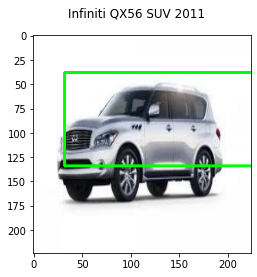

In [ ]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd

#Pickup a random image number
img_num = np.random.randint(0, df_tidytest.shape[0])
#Read the image and draw a rectangle as per bounding box information
img = cv2.imread(df_tidytest.loc[img_num,'Filepath'])
img = cv2.resize(img,(224, 224))
(h, w) = img.shape[:2]
x_ratio = 224/w
y_ratio = 224/h
cv2.rectangle(img, 
             (int(df_tidytest.loc[img_num, 'StartX']*x_ratio),int(df_tidytest.loc[img_num, 'StartY']*y_ratio)),
             (int(df_tidytest.loc[img_num, 'EndX']*x_ratio),int(df_tidytest.loc[img_num, 'EndY']*y_ratio)), 
             (0,255,0),
             2)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.suptitle(df_tidytest.loc[img_num, 'Classname'])
plt.imshow(img)
plt.show()

In [ ]:
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w+")
f.write("\n".join(TestFiles))
f.close()

[INFO] saving testing filenames...


In [ ]:
df_tidy.to_pickle(DF_TRAIN_PATH)

In [ ]:
DF_train = pd.read_pickle(DF_TRAIN_PATH)
DF_train.head()

,Image Name,StartX,StartY,EndX,EndY,Image class,Classname,X1,Y1,X2,Y2,Filepath
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,0.065000,0.290000,0.948333,0.937500,/content/drive/My Drive/Capstone Data/Car Imag...
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0.040000,0.171852,0.964444,0.869630,/content/drive/My Drive/Capstone Data/Car Imag...
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0.132812,0.227083,0.939063,0.793750,/content/drive/My Drive/Capstone Data/Car Imag...
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,0.295714,0.283550,0.706667,0.790765,/content/drive/My Drive/Capstone Data/Car Imag...
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,0.097222,0.333333,0.923611,0.916667,/content/drive/My Drive/Capstone Data/Car Imag...


In [ ]:
df_tidytest.to_pickle(DF_TEST_PATH)

In [ ]:
DF_test = pd.read_pickle(DF_TEST_PATH)
DF_test.head()

,Image Name,StartX,StartY,EndX,EndY,Image class,Classname,X1,Y1,X2,Y2,Filepath
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007,0.108696,0.285714,0.891304,0.807692,/content/drive/My Drive/Capstone Data/Car Imag...
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012,0.156250,0.052778,0.900000,0.563889,/content/drive/My Drive/Capstone Data/Car Imag...
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012,0.049805,0.141700,0.945312,0.889339,/content/drive/My Drive/Capstone Data/Car Imag...
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012,0.104688,0.175000,0.907813,0.847917,/content/drive/My Drive/Capstone Data/Car Imag...
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012,0.233333,0.404826,0.988333,0.908847,/content/drive/My Drive/Capstone Data/Car Imag...


In [ ]:
pickle.dump(data, open(TRAIN_IMAGES_PROCESSED, 'wb'))
pickle.dump(testdata, open(TEST_IMAGES_PROCESSED, 'wb'))

In [ ]:
file = open(TRAIN_IMAGES_PROCESSED,'rb')
_data = pickle.load(file)

file = open(TEST_IMAGES_PROCESSED,'rb')
_testdata = pickle.load(file)

In [ ]:
pickle.dump(bboxes, open(TRAIN_BBOXES, 'wb'))
pickle.dump(testbboxes, open(TEST_BBOXES, 'wb'))

In [ ]:
file = open(TRAIN_BBOXES, 'rb')
_bboxes = pickle.load(file)

file = open(TEST_BBOXES, 'rb')
_testbboxes = pickle.load(file)

In [ ]:
'''
_data.shape
_testdata.shape
_bboxes.shape
_testbboxes.shape
'''

In [ ]:
ImageClass = DF_train["Image class"]
_ImageClass = DF_test["Image class"]

In [ ]:
lb = LabelBinarizer()
trainlabels = lb.fit_transform(ImageClass)
testlabels = lb.fit_transform(_ImageClass)

In [ ]:
trainImages = np.array(_data, dtype="float32") / 255.0
trainLabels = np.array(trainlabels)
trainBBoxes = np.array(_bboxes, dtype="float32")

In [ ]:
print(trainImages.shape)
print(trainLabels.shape)
print(trainBBoxes.shape)

(8144, 224, 224, 3)
(8144, 196)
(8144, 4)


In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
testImages = np.array(_testdata, dtype="float32") / 255.0
testLabels = np.array(testlabels)
testBBoxes = np.array(_testbboxes, dtype="float32")

In [ ]:
print(testImages.shape)
print(testLabels.shape)
print(testBBoxes.shape)

(8041, 224, 224, 3)
(8041, 196)
(8041, 4)
